In [41]:
import pandas as pd
import os
import glob
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Markdown
import seaborn as sns
import numpy as np

from metadata.etfs import etfs_large, etfs_small
from utils.conn_data import load_pickle

plt.style.use('seaborn')

In [42]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
des = pd.read_csv(os.path.join(os.getcwd(), 'data', 'utils', 'fredmd_description.csv'), sep=';')

fs_methods = ["lasso", "multivariate-granger", "pairwise-granger", "var-lingam", "dynotears"]
metric_names = ["stability", "mse", "mae"]
etf_focus = None
stability_threshold = 0.8
plot_ts = False

In [43]:
warnings.simplefilter("ignore")


all_metrics = []
all_rolling_metrics = []
all_stability = []
all_parents = []
for fs in fs_methods:

    if plot_ts:
        display(Markdown(f"## {fs}"))

    # list results files with glob
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", "*.pickle"))

    # load results files
    stability = []
    metrics = []
    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]

        if (etf_focus != etf) and (etf_focus is not None):
            continue
        else:
            pass

        obj = load_pickle(path=file)

        # plot predictions
        predictions_df = obj['predictions']
        predictions_2020_df = predictions_df.loc["2020-01-01":"2020-12-01"]

        if plot_ts:
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.set_title(label=f'OOS Predictions for {etf}', fontsize=15)
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["prediction"], label="predictions")
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["true"], label="true")
            plt.xlabel("Date")
            plt.ylabel("Returns")
            plt.legend(loc='best', fontsize=10)   
            plt.show()

        # compute rolling mse
        rolling_metric_df = predictions_df.copy()
        rolling_metric_df["diff"] = rolling_metric_df["true"] - rolling_metric_df["prediction"]

        # rolling mse
        rolling_metric_df["rolling_var"] = rolling_metric_df["prediction"].rolling(12).var()
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["true"] - rolling_metric_df["prediction"]).pow(2).rolling(12).mean()
        rolling_metric_df["rolling_mse"] = rolling_metric_df["rolling_var"] + rolling_metric_df["rolling_bias"]
        rolling_metric_df["rolling_var"] = (rolling_metric_df["rolling_var"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["rolling_bias"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df = rolling_metric_df[["rolling_mse", "rolling_var", "rolling_bias"]]

        # add info
        rolling_metric_df["fs"] = fs
        rolling_metric_df["etf"] = etf

        # melt
        melt_rolling_metric_df = rolling_metric_df.reset_index().melt(["date", "fs", "etf"])

        # compute forecast metrics
        mse = mean_squared_error(predictions_df["true"], predictions_df["prediction"])
        mae = mean_absolute_error(predictions_df["true"], predictions_df["prediction"])
        mse_2020 = mean_squared_error(predictions_2020_df["true"], predictions_2020_df["prediction"])
        mae_2020 = mean_absolute_error(predictions_2020_df["true"], predictions_2020_df["prediction"])
        # bias = (predictions_df["true"] - np.mean(predictions_df["prediction"], axis=1)) ** 2
        # var = np.var(predictions_df["prediction"], axis=1)

        # compute cluster stability metrics
        parents_of_target_df = obj["parents_of_target"]

        # save parents
        parents_of_target_df["fs"] = fs
        parents_of_target_df["etf"] = etf
        
        tot = len(parents_of_target_df["date"].unique())
        stability_df = (parents_of_target_df.fillna(0).groupby(["cluster"]).sum()[["value"]] / tot).sort_values(by="value", ascending=False)
        stability_df = pd.concat({etf: stability_df}, names=['etf'])
        stability.append(stability_df)

        stability_measure = (stability_df).sum().iloc[0] / stability_df.shape[0]
        metrics_df = pd.DataFrame({
            "fs": fs, 
            "etf": etf, 
            "mse": [mse],
            "mae": [mae], 
            # "bias": [bias],
            # "var": [var],
            "mse_2020": [mse_2020], 
            "mae_2020": [mae_2020],
            "stability": stability_measure})
        metrics.append(metrics_df)
        all_rolling_metrics.append(melt_rolling_metric_df)
        all_parents.append(parents_of_target_df)
    
    all_metrics.append(pd.concat(metrics).set_index(["fs", "etf"]))
    all_stability.append(pd.concat(stability))
all_metrics_df = pd.concat(all_metrics)
all_rolling_metrics_df = pd.concat(all_rolling_metrics)
all_parents_df = pd.concat(all_parents)
melted_all_metrics_df = all_metrics_df.reset_index().melt(id_vars=["fs", "etf"])

## Boxplots with summary statistics

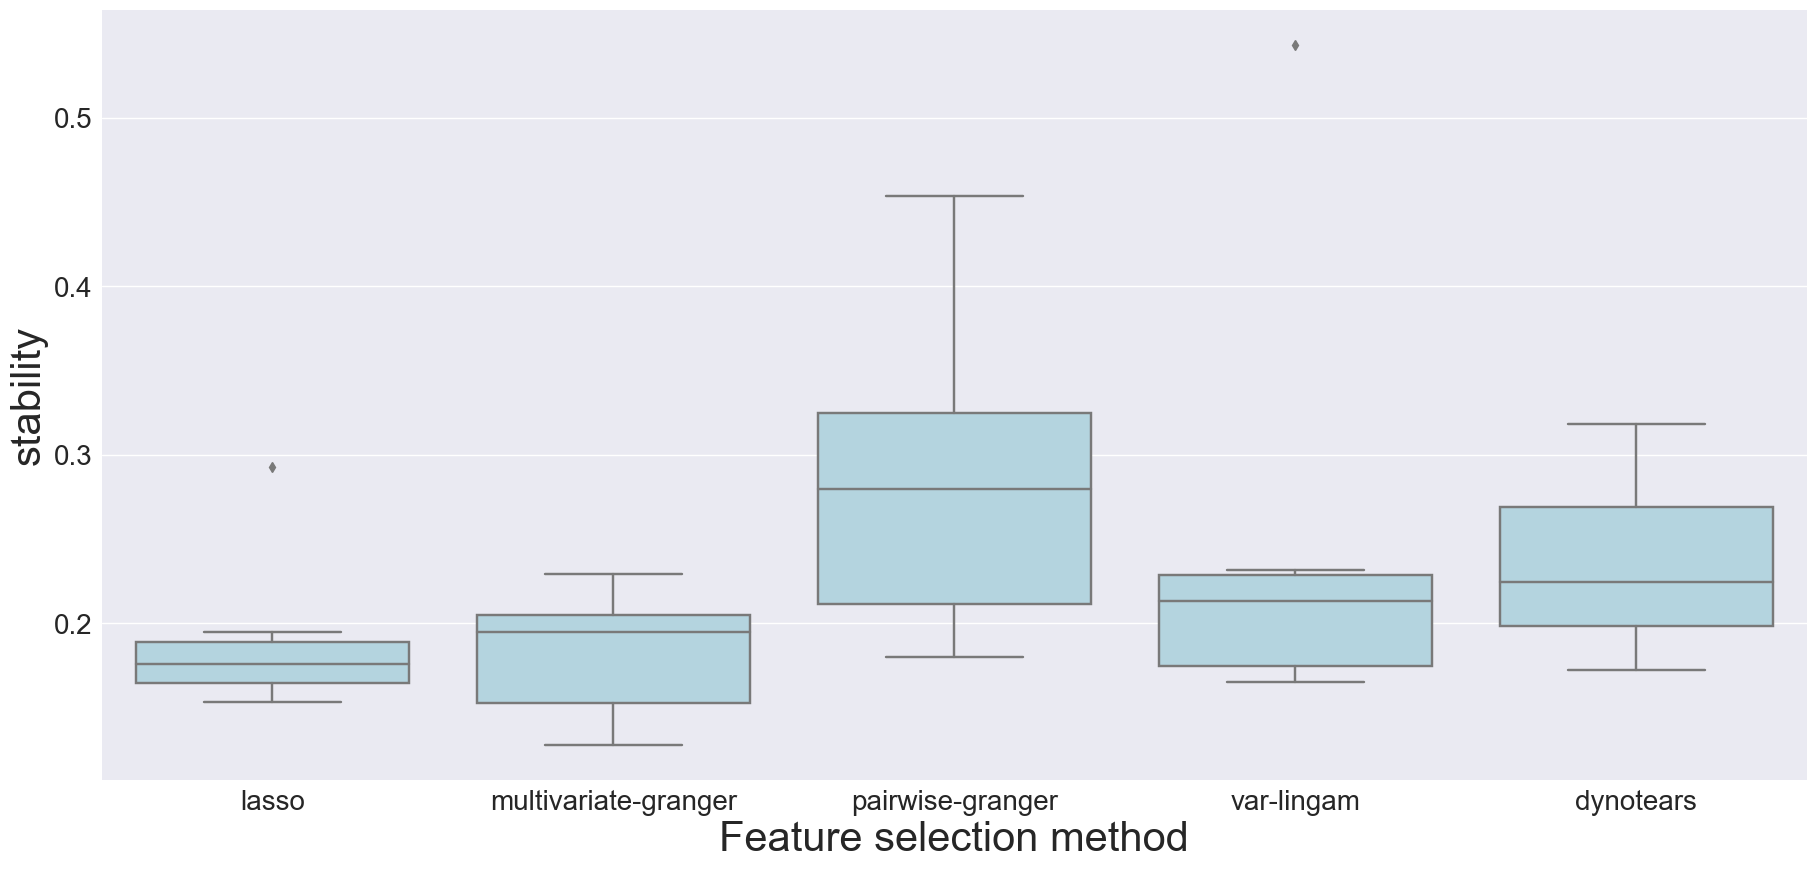

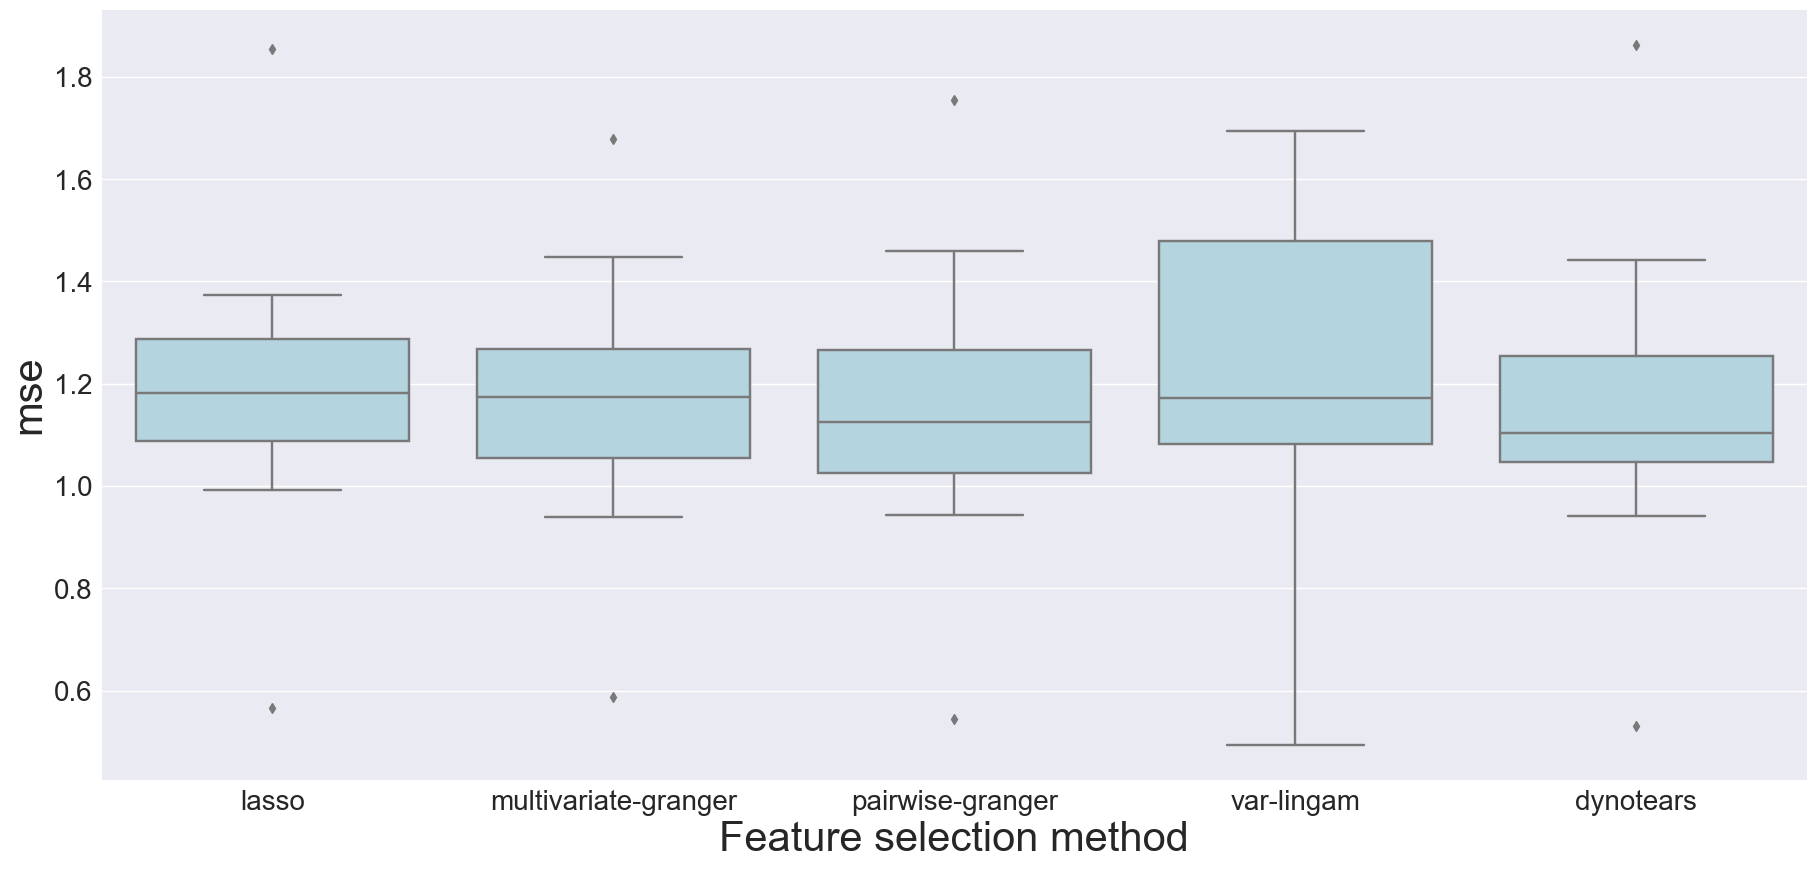

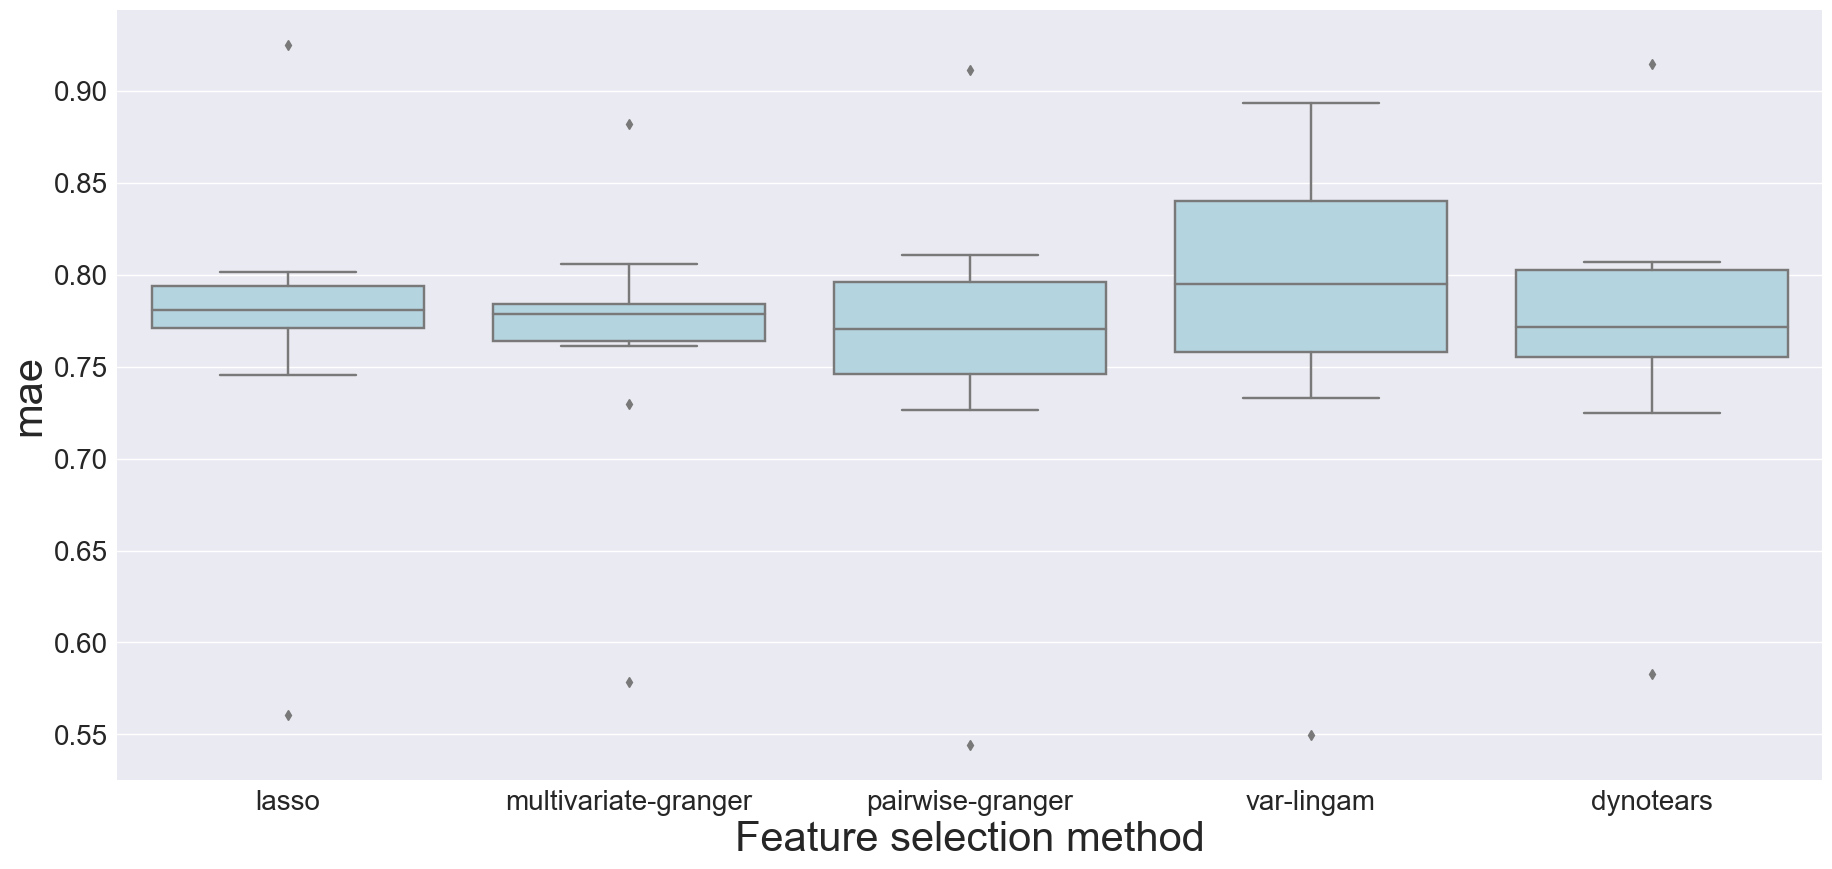

In [44]:
metric_name = "mse"
for m in metric_names:
    boxplot_df = melted_all_metrics_df.loc[(melted_all_metrics_df["variable"] == m)].drop(["variable"], axis=1)

    fig, ax = plt.subplots(figsize=(22, 10))
    sns.boxplot(x="fs", y='value',data=boxplot_df, ax=ax, color='lightblue')
    ax.set_ylabel(m, fontsize=30)
    ax.set_xlabel("Feature selection method", fontsize=30)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    # ax.legend(loc="best",fontsize=15)
    # fig.savefig('img/oos_auc_fs_methods_distr.png')

### Prediction error over time

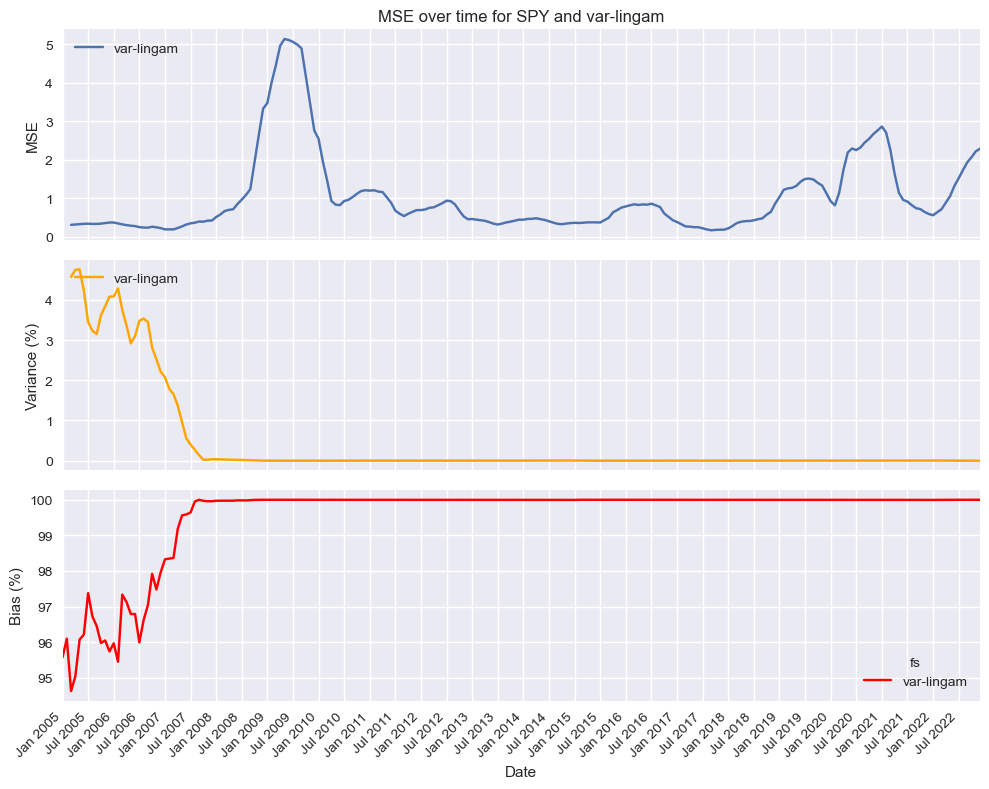

In [45]:
etf = "SPY"
fs = "var-lingam"

# mse
etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
etf_rolling_metrics_df = etf_rolling_metrics_df.rolling(3).mean()
etf_rolling_metrics_df["diff_lasso_var-lingam"] = 1

# variance
etf_rolling_variance_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_var")].pivot_table(index=["date"], columns=["fs", "variable"], values=["value"])
etf_rolling_variance_df.columns = etf_rolling_variance_df.columns.droplevel()
etf_rolling_variance_df = etf_rolling_variance_df.rolling(3).mean()
etf_rolling_variance_df.columns = etf_rolling_variance_df.columns.droplevel(1) 

# bias
etf_rolling_bias_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_bias")].pivot_table(index=["date"], columns=["fs", "variable"], values=["value"])
etf_rolling_bias_df.columns = etf_rolling_bias_df.columns.droplevel()
etf_rolling_biass_df = etf_rolling_bias_df.rolling(3).mean()
etf_rolling_bias_df.columns = etf_rolling_bias_df.columns.droplevel(1) 

# plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# plotting on the upper subplot
etf_rolling_metrics_df.drop(["diff_lasso_var-lingam"], axis=1).plot(ax=axs[0])
axs[0].set_title(f'MSE over time for {etf} and {fs}')
axs[0].set_ylabel('MSE')
axs[0].legend(loc='upper left')

# plotting on the upper subplot
etf_rolling_variance_df.plot(ax=axs[1], color="orange")
# axs[1].set_title(f'Variance over time for {etf}')
axs[1].set_ylabel('Variance (%)')
axs[1].legend(loc='upper left')

# plotting on the lower subplot
etf_rolling_bias_df.plot(ax=axs[2], color="red")
# axs[2].set_title(f'Bias over time for {etf}')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Bias (%)')

# adding months and years to the index of the plot
tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
axs[2].set_xticks(tick_positions)
axs[2].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

# adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

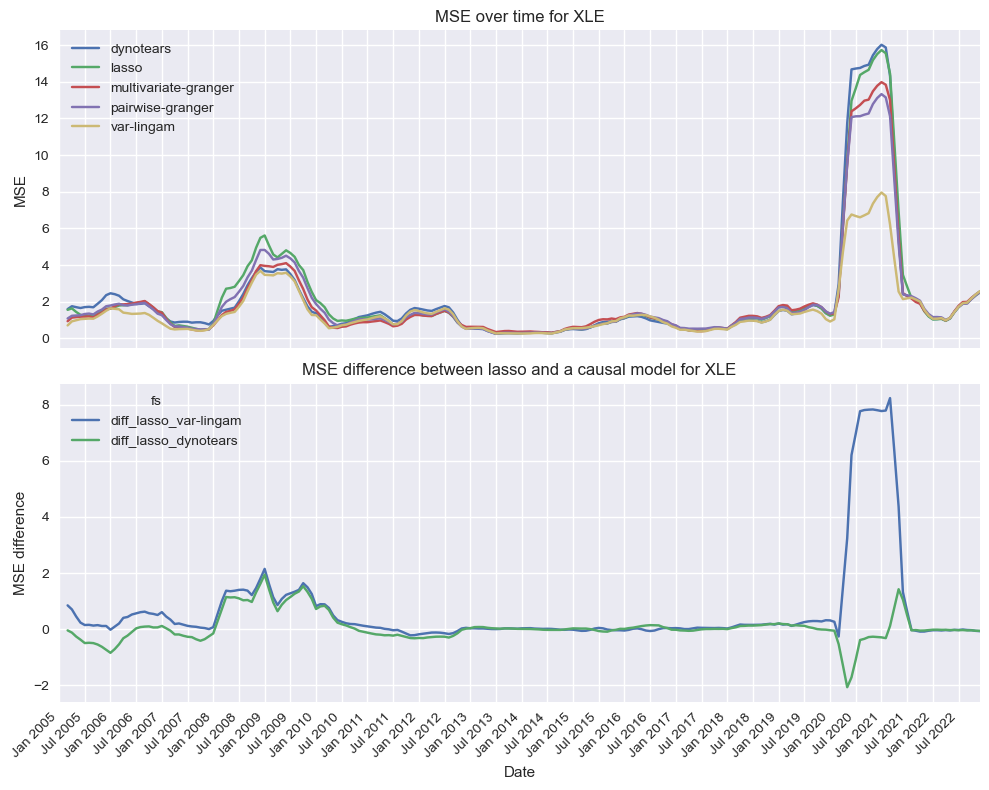

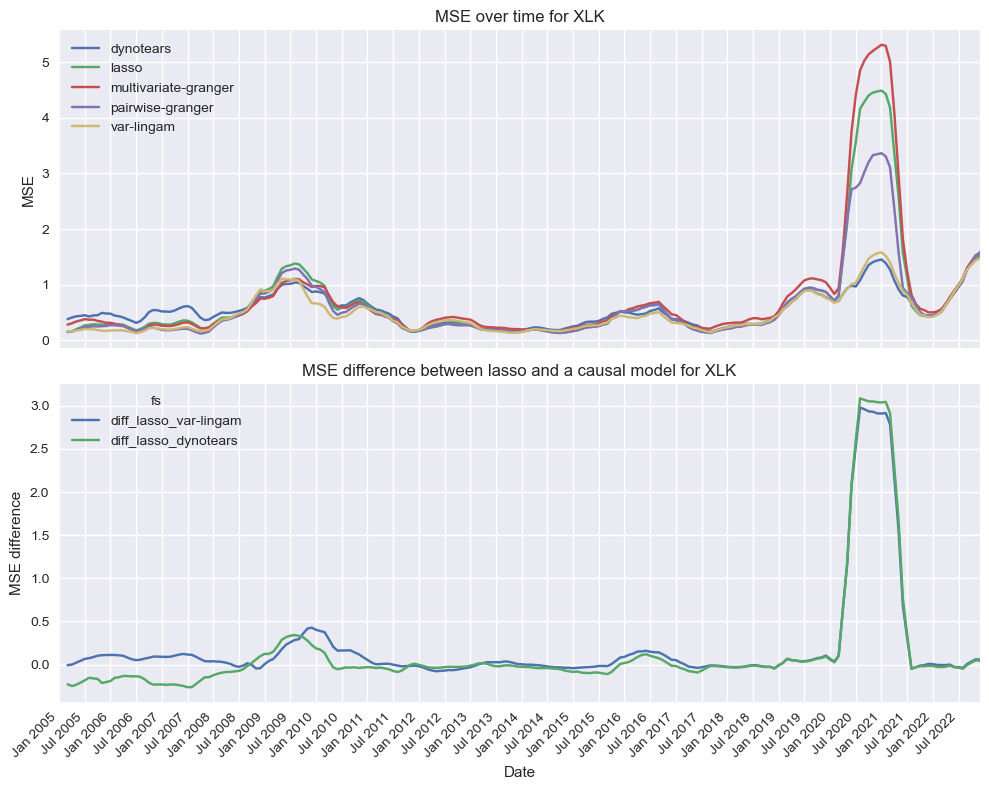

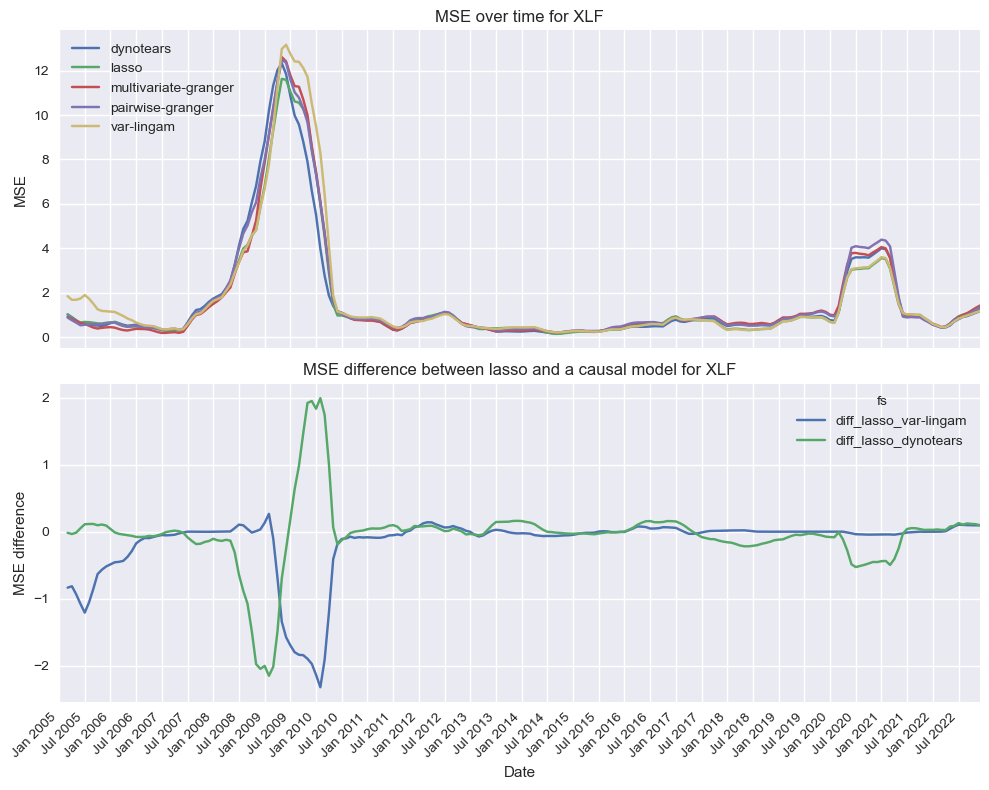

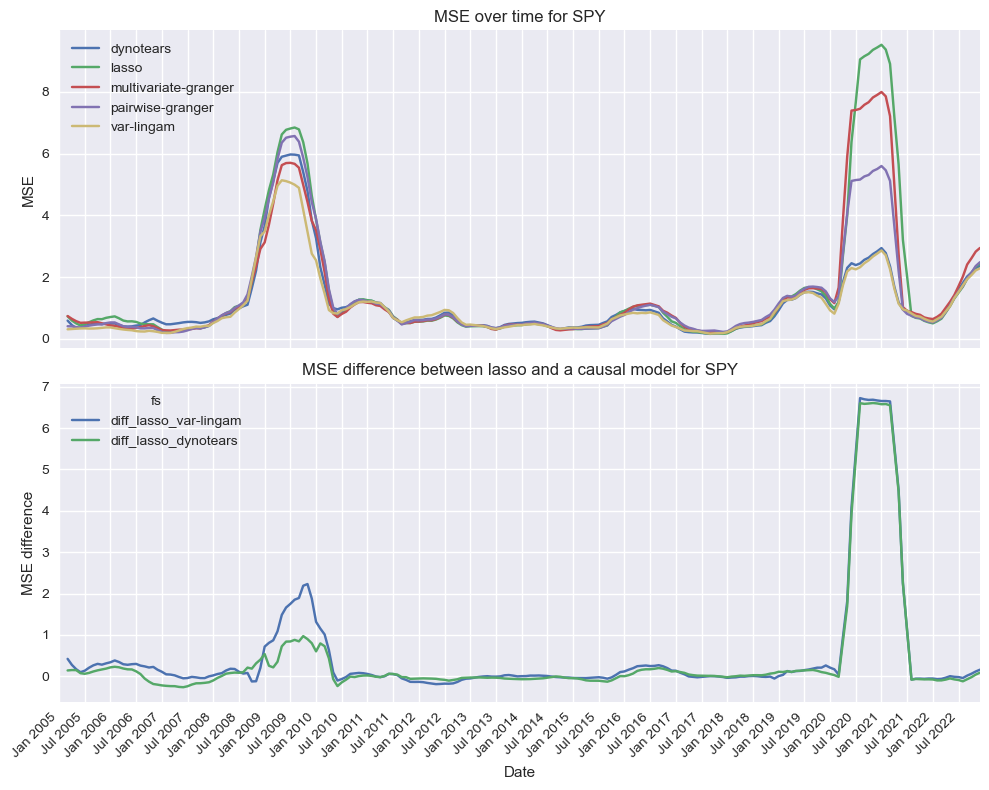

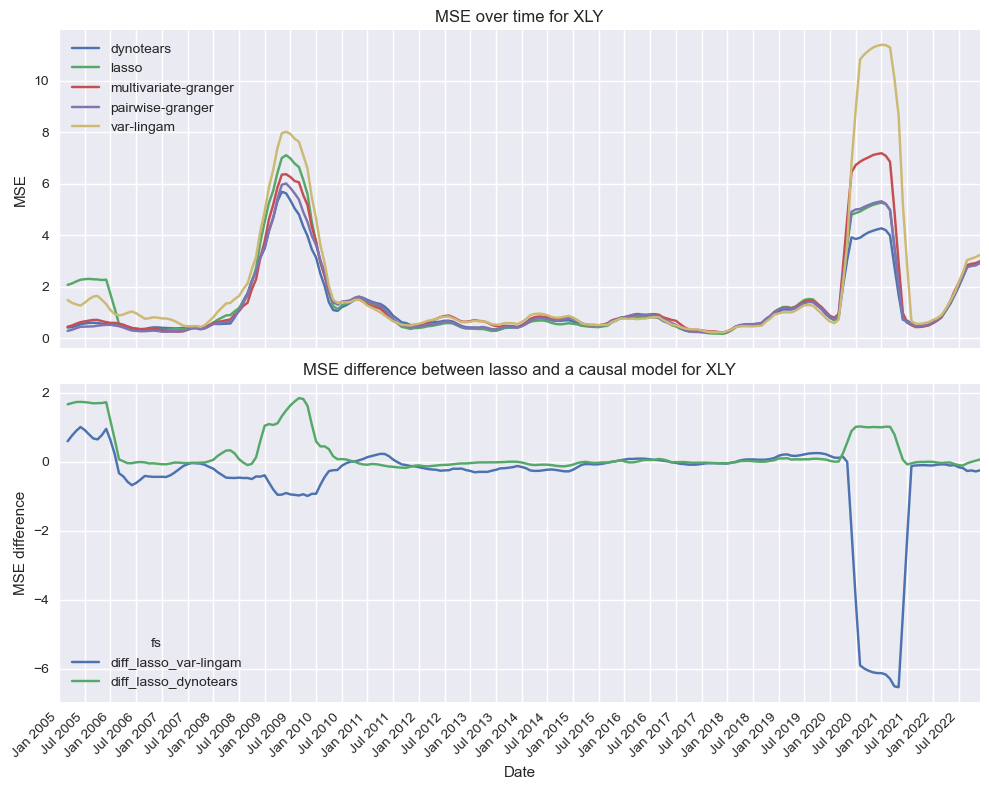

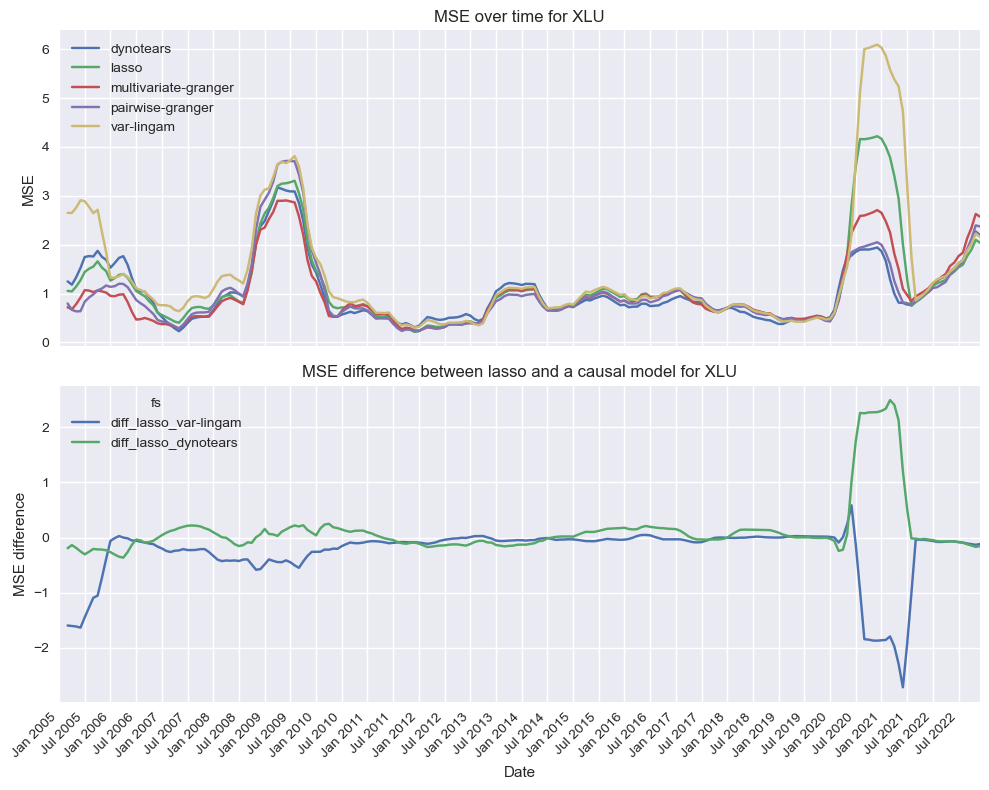

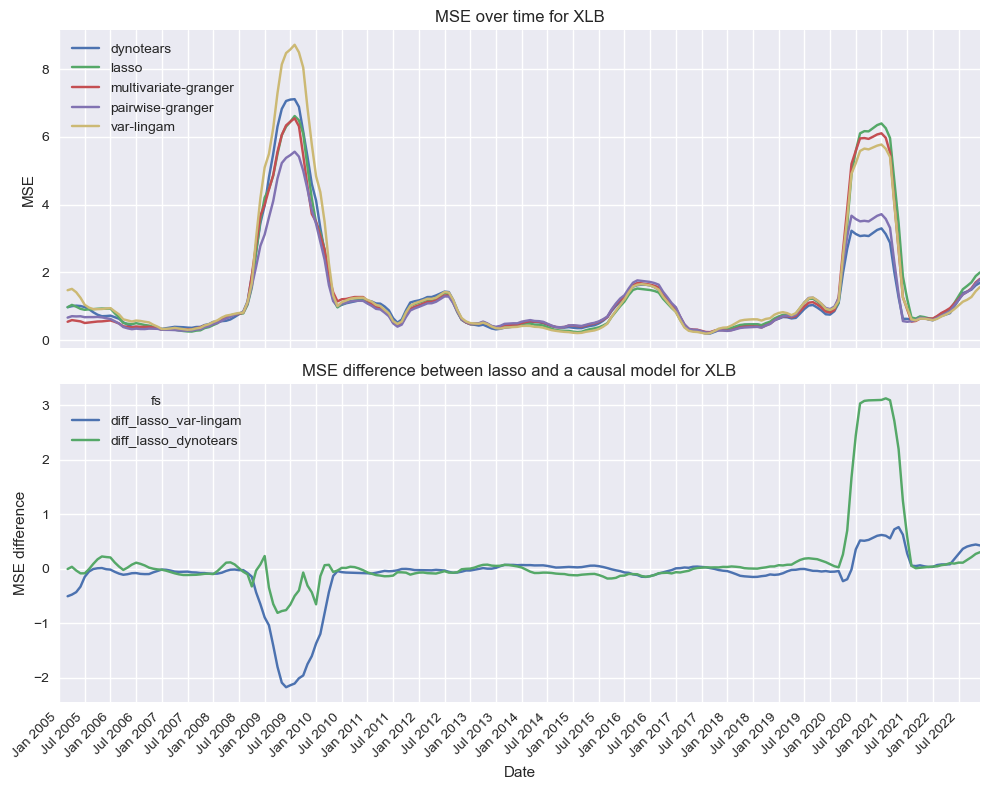

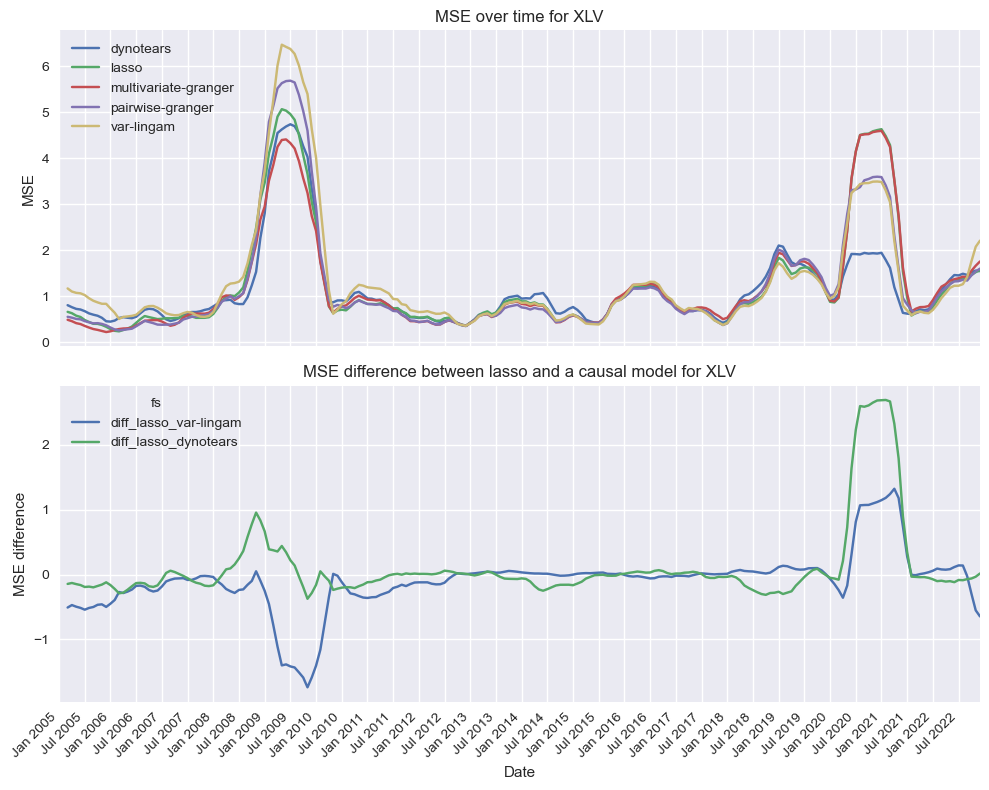

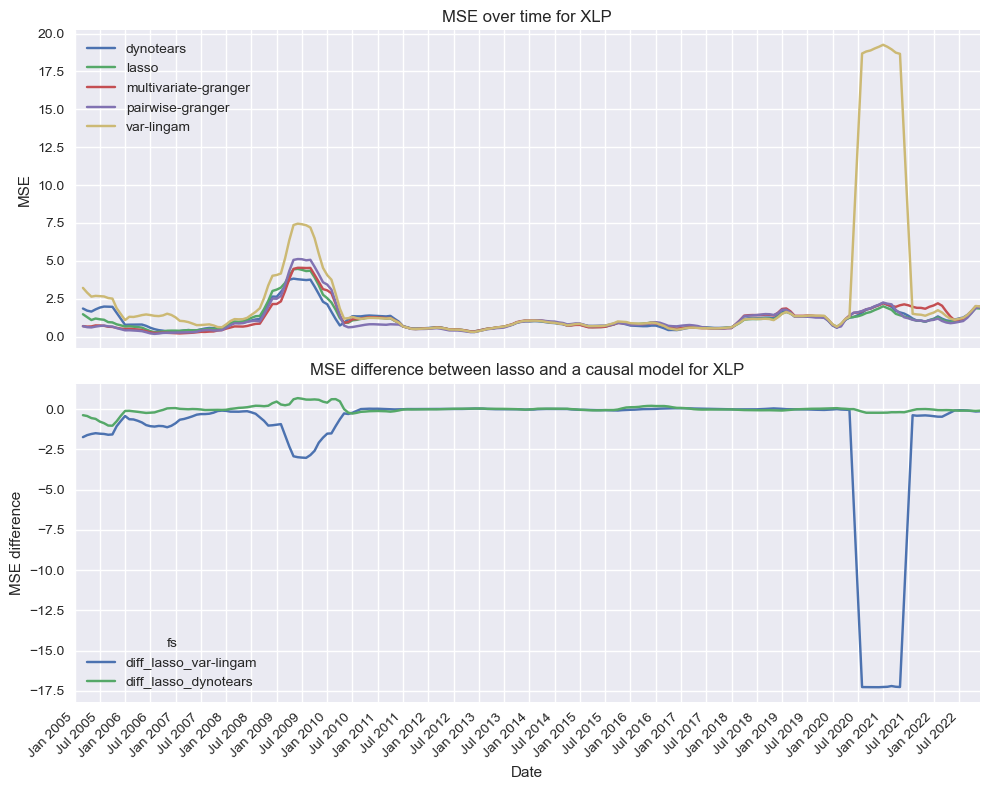

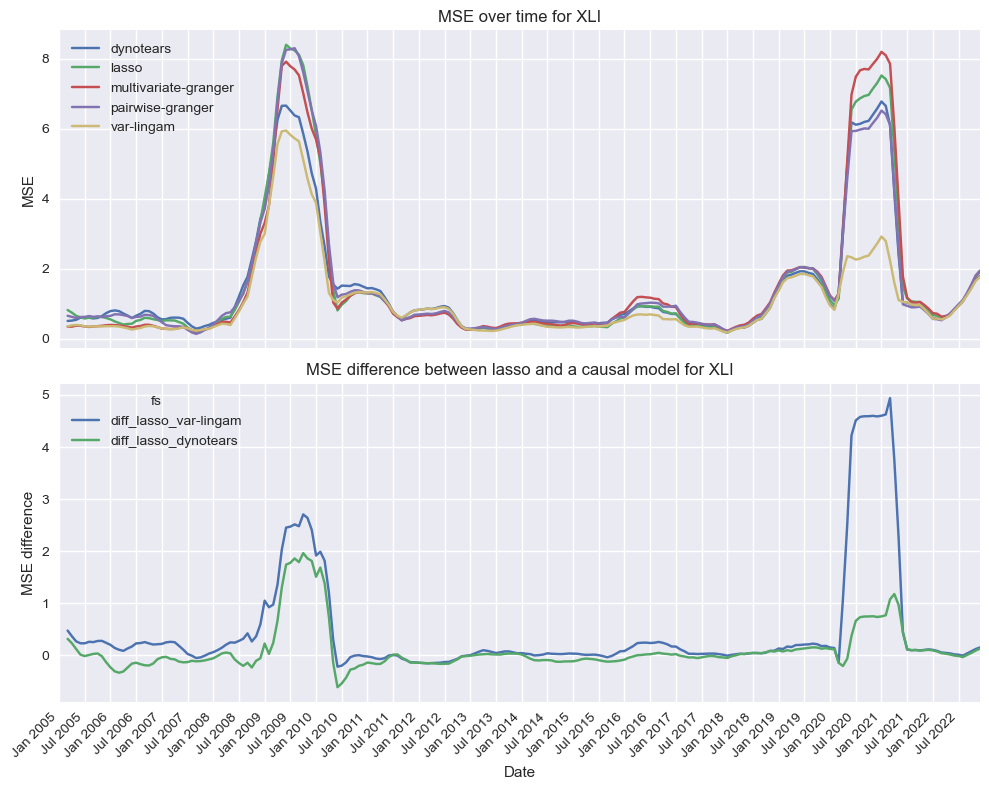

In [46]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

for etf in all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df = etf_rolling_metrics_df.rolling(3).mean()
    etf_rolling_metrics_df["diff_lasso_var-lingam"] = etf_rolling_metrics_df["lasso"] - etf_rolling_metrics_df["var-lingam"]
    etf_rolling_metrics_df["diff_lasso_dynotears"] = etf_rolling_metrics_df["lasso"] - etf_rolling_metrics_df["dynotears"]

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop(["diff_lasso_var-lingam", "diff_lasso_dynotears"], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'MSE over time for {etf}')
    axs[0].set_ylabel('MSE')
    axs[0].legend(loc='upper left')

    # Plotting on the lower subplot
    etf_rolling_metrics_df[["diff_lasso_var-lingam", "diff_lasso_dynotears"]].plot(ax=axs[1])
    axs[1].set_title(f'MSE difference between lasso and a causal model for {etf}')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('MSE difference')

    # Adding months and years to the index of the plot
    tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plot
    plt.show()

## Selected parents over time

In [47]:
etf = "SPY"
fss = ["var-lingam", "multivariate-granger"]

In [48]:
# select rows that match conditions fss
selected_melt_df = all_parents_df.loc[(all_parents_df["fs"] == fss[0]) & (all_parents_df["etf"] == etf)]

selected_melt_df.pivot_table(index=["date"], columns=["etf", "fs", "cluster"], values=["value"]).loc["2020-01-01":"2020-05-01"]

Empty DataFrame
Columns: [(value, SPY, var-lingam, 2.0), (value, SPY, var-lingam, 5.0), (value, SPY, var-lingam, 6.0), (value, SPY, var-lingam, 9.0), (value, SPY, var-lingam, 11.0), (value, SPY, var-lingam, 12.0), (value, SPY, var-lingam, 13.0), (value, SPY, var-lingam, 16.0), (value, SPY, var-lingam, 19.0)]
Index: []

In [49]:
# select rows that match conditions fss
selected_melt_df = all_parents_df.loc[(all_parents_df["fs"] == fss[1]) & (all_parents_df["etf"] == etf)]

selected_melt_df.pivot_table(index=["date"], columns=["etf", "fs", "cluster"], values=["value"]).loc["2020-01-01":"2020-05-01"]

value                                               \
etf                         SPY                                                
fs         multivariate-granger                                                
cluster                    1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0   
date                                                                           
2020-01-31                  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0   
2020-02-29                  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0   
2020-03-31                  1.0  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN   
2020-04-30                  1.0  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN   

                                     
etf                                  
fs                                   
cluster    11.0 14.0 16.0 17.0 18.0  
date                                 
2020-01-31  1.0  NaN  NaN  1.0  NaN  
2020-02-29  1.0  NaN  NaN  1.0  NaN  
2020-03-31  1.0  NaN  NaN  1.0  NaN  
2020-04-30  1.0  NaN  NaN  1.0  NaN

## Table of summary statistics

In [50]:
etf = "XLP"

all_metrics_df[all_metrics_df.index.isin([etf], level=1)].sort_values(by="mse", ascending=True)

,,mse,mae,mse_2020,mae_2020,stability
fs,etf,,,,,
pairwise-granger,XLP,1.043839,0.771313,2.158884,1.223733,0.180031
multivariate-granger,XLP,1.049828,0.777850,2.167419,1.186205,0.127930
dynotears,XLP,1.079220,0.789886,2.325164,1.289004,0.194126
lasso,XLP,1.085836,0.801480,2.124085,1.215363,0.181362
var-lingam,XLP,1.694379,0.893676,10.914113,2.038251,0.187442


In [51]:
all_metrics_df.sort_values(by=["mse"], ascending=True)

mse       mae   mse_2020  mae_2020  stability
fs                   etf                                                    
var-lingam           XLK  0.494647  0.549699   1.685281  1.225282   0.170455
dynotears            XLK  0.531166  0.582844   1.566468  1.166453   0.279736
pairwise-granger     XLK  0.545329  0.544404   2.686396  1.338770   0.453744
lasso                XLK  0.566245  0.560388   2.832204  1.353069   0.292707
multivariate-granger XLK  0.587403  0.578589   3.004367  1.468119   0.218950
                     XLU  0.938658  0.729912   2.406488  1.271785   0.129589
dynotears            XLU  0.941555  0.724864   1.991894  1.047083   0.212628
pairwise-granger     XLU  0.943798  0.726217   1.866288  1.137830   0.185516
lasso                XLU  0.992072  0.745537   3.248113  1.475844   0.190941
pairwise-granger     XLB  1.019934  0.739886   3.043827  1.191589   0.311420
dynotears            XLV  1.035120  0.775276   2.082889  1.196194   0.318439
var-lingam           SPY  1.038721  0.752115   3.104409  1.449094   0.220833
pairwise-granger     XLP  1.043839  0.771313   2.158884  1.223733   0.180031
multivariate-granger XLP  1.049828  0.777850   2.167419  1.186205   0.127930
var-lingam           XLI  1.061012  0.732811   3.167997  1.300984   0.166008
multivariate-granger XLV  1.071522  0.772837   3.748966  1.524765   0.202014
dynotears            XLP  1.079220  0.789886   2.325164  1.289004   0.194126
lasso                XLP  1.085836  0.801480   2.124085  1.215363   0.181362
dynotears            SPY  1.091408  0.768029   3.179373  1.460585   0.236684
lasso                XLV  1.092135  0.781733   3.776898  1.546877   0.180617
pairwise-granger     XLV  1.092298  0.773029   3.311114  1.388716   0.339608
dynotears            XLB  1.115168  0.767686   3.204107  1.334212   0.298301
lasso                XLB  1.118353  0.769275   4.272607  1.542319   0.194921
dynotears            XLY  1.120180  0.751363   3.859839  1.381812   0.236941
multivariate-granger XLB  1.136185  0.761378   4.049748  1.418296   0.229141
var-lingam           XLU  1.147135  0.797669   4.193851  1.620898   0.213063
                     XLV  1.148636  0.792043   3.168952  1.344058   0.231498
pairwise-granger     SPY  1.157833  0.769560   4.418554  1.506459   0.325190
                     XLY  1.188956  0.764977   4.875142  1.593212   0.324201
var-lingam           XLB  1.194002  0.776230   4.204922  1.437719   0.213436
multivariate-granger SPY  1.213452  0.780146   5.566348  1.653121   0.198788
lasso                SPY  1.244962  0.779595   6.185961  1.782834   0.170980
multivariate-granger XLI  1.262920  0.785325   5.662212  1.739682   0.145652
lasso                XLY  1.268519  0.776891   4.406935  1.445625   0.168974
multivariate-granger XLY  1.270702  0.779119   5.759457  1.666149   0.206013
pairwise-granger     XLI  1.291375  0.803658   4.878546  1.532784   0.244543
lasso                XLI  1.294805  0.794430   5.581518  1.731292   0.157470
dynotears            XLI  1.299971  0.806804   5.808571  1.670883   0.172357
lasso                XLF  1.372806  0.791920   3.404587  1.384949   0.153325
dynotears            XLF  1.442579  0.806656   3.669740  1.459406   0.210714
multivariate-granger XLF  1.447888  0.805740   3.692571  1.433947   0.174174
pairwise-granger     XLF  1.458638  0.811036   3.363077  1.342126   0.200000
var-lingam           XLE  1.473339  0.852723   8.775812  2.130482   0.543478
                     XLF  1.480025  0.816845   3.432046  1.408405   0.165000
                     XLY  1.525045  0.848040   8.400505  2.070190   0.231333
multivariate-granger XLE  1.678222  0.881981  12.135796  2.570470   0.190804
var-lingam           XLP  1.694379  0.893676  10.914113  2.038251   0.187442
pairwise-granger     XLE  1.754341  0.911577  12.351514  2.577480   0.247640
lasso                XLE  1.855060  0.925284  13.782137  2.823644   0.162832
dynotears            XLE  1.862922  0.914745  14.928712  2.741743   0.180988

In [52]:
all_metrics_df.sort_values(by="mae", ascending=True)

mse       mae   mse_2020  mae_2020  stability
fs                   etf                                                    
pairwise-granger     XLK  0.545329  0.544404   2.686396  1.338770   0.453744
var-lingam           XLK  0.494647  0.549699   1.685281  1.225282   0.170455
lasso                XLK  0.566245  0.560388   2.832204  1.353069   0.292707
multivariate-granger XLK  0.587403  0.578589   3.004367  1.468119   0.218950
dynotears            XLK  0.531166  0.582844   1.566468  1.166453   0.279736
                     XLU  0.941555  0.724864   1.991894  1.047083   0.212628
pairwise-granger     XLU  0.943798  0.726217   1.866288  1.137830   0.185516
multivariate-granger XLU  0.938658  0.729912   2.406488  1.271785   0.129589
var-lingam           XLI  1.061012  0.732811   3.167997  1.300984   0.166008
pairwise-granger     XLB  1.019934  0.739886   3.043827  1.191589   0.311420
lasso                XLU  0.992072  0.745537   3.248113  1.475844   0.190941
dynotears            XLY  1.120180  0.751363   3.859839  1.381812   0.236941
var-lingam           SPY  1.038721  0.752115   3.104409  1.449094   0.220833
multivariate-granger XLB  1.136185  0.761378   4.049748  1.418296   0.229141
pairwise-granger     XLY  1.188956  0.764977   4.875142  1.593212   0.324201
dynotears            XLB  1.115168  0.767686   3.204107  1.334212   0.298301
                     SPY  1.091408  0.768029   3.179373  1.460585   0.236684
lasso                XLB  1.118353  0.769275   4.272607  1.542319   0.194921
pairwise-granger     SPY  1.157833  0.769560   4.418554  1.506459   0.325190
                     XLP  1.043839  0.771313   2.158884  1.223733   0.180031
multivariate-granger XLV  1.071522  0.772837   3.748966  1.524765   0.202014
pairwise-granger     XLV  1.092298  0.773029   3.311114  1.388716   0.339608
dynotears            XLV  1.035120  0.775276   2.082889  1.196194   0.318439
var-lingam           XLB  1.194002  0.776230   4.204922  1.437719   0.213436
lasso                XLY  1.268519  0.776891   4.406935  1.445625   0.168974
multivariate-granger XLP  1.049828  0.777850   2.167419  1.186205   0.127930
                     XLY  1.270702  0.779119   5.759457  1.666149   0.206013
lasso                SPY  1.244962  0.779595   6.185961  1.782834   0.170980
multivariate-granger SPY  1.213452  0.780146   5.566348  1.653121   0.198788
lasso                XLV  1.092135  0.781733   3.776898  1.546877   0.180617
multivariate-granger XLI  1.262920  0.785325   5.662212  1.739682   0.145652
dynotears            XLP  1.079220  0.789886   2.325164  1.289004   0.194126
lasso                XLF  1.372806  0.791920   3.404587  1.384949   0.153325
var-lingam           XLV  1.148636  0.792043   3.168952  1.344058   0.231498
lasso                XLI  1.294805  0.794430   5.581518  1.731292   0.157470
var-lingam           XLU  1.147135  0.797669   4.193851  1.620898   0.213063
lasso                XLP  1.085836  0.801480   2.124085  1.215363   0.181362
pairwise-granger     XLI  1.291375  0.803658   4.878546  1.532784   0.244543
multivariate-granger XLF  1.447888  0.805740   3.692571  1.433947   0.174174
dynotears            XLF  1.442579  0.806656   3.669740  1.459406   0.210714
                     XLI  1.299971  0.806804   5.808571  1.670883   0.172357
pairwise-granger     XLF  1.458638  0.811036   3.363077  1.342126   0.200000
var-lingam           XLF  1.480025  0.816845   3.432046  1.408405   0.165000
                     XLY  1.525045  0.848040   8.400505  2.070190   0.231333
                     XLE  1.473339  0.852723   8.775812  2.130482   0.543478
multivariate-granger XLE  1.678222  0.881981  12.135796  2.570470   0.190804
var-lingam           XLP  1.694379  0.893676  10.914113  2.038251   0.187442
pairwise-granger     XLE  1.754341  0.911577  12.351514  2.577480   0.247640
dynotears            XLE  1.862922  0.914745  14.928712  2.741743   0.180988
lasso                XLE  1.855060  0.925284  13.782137  2.823644   0.162832

In [53]:
all_metrics_df.sort_values(by="stability", ascending=False)

mse       mae   mse_2020  mae_2020  stability
fs                   etf                                                    
var-lingam           XLE  1.473339  0.852723   8.775812  2.130482   0.543478
pairwise-granger     XLK  0.545329  0.544404   2.686396  1.338770   0.453744
                     XLV  1.092298  0.773029   3.311114  1.388716   0.339608
                     SPY  1.157833  0.769560   4.418554  1.506459   0.325190
                     XLY  1.188956  0.764977   4.875142  1.593212   0.324201
dynotears            XLV  1.035120  0.775276   2.082889  1.196194   0.318439
pairwise-granger     XLB  1.019934  0.739886   3.043827  1.191589   0.311420
dynotears            XLB  1.115168  0.767686   3.204107  1.334212   0.298301
lasso                XLK  0.566245  0.560388   2.832204  1.353069   0.292707
dynotears            XLK  0.531166  0.582844   1.566468  1.166453   0.279736
pairwise-granger     XLE  1.754341  0.911577  12.351514  2.577480   0.247640
                     XLI  1.291375  0.803658   4.878546  1.532784   0.244543
dynotears            XLY  1.120180  0.751363   3.859839  1.381812   0.236941
                     SPY  1.091408  0.768029   3.179373  1.460585   0.236684
var-lingam           XLV  1.148636  0.792043   3.168952  1.344058   0.231498
                     XLY  1.525045  0.848040   8.400505  2.070190   0.231333
multivariate-granger XLB  1.136185  0.761378   4.049748  1.418296   0.229141
var-lingam           SPY  1.038721  0.752115   3.104409  1.449094   0.220833
multivariate-granger XLK  0.587403  0.578589   3.004367  1.468119   0.218950
var-lingam           XLB  1.194002  0.776230   4.204922  1.437719   0.213436
                     XLU  1.147135  0.797669   4.193851  1.620898   0.213063
dynotears            XLU  0.941555  0.724864   1.991894  1.047083   0.212628
                     XLF  1.442579  0.806656   3.669740  1.459406   0.210714
multivariate-granger XLY  1.270702  0.779119   5.759457  1.666149   0.206013
                     XLV  1.071522  0.772837   3.748966  1.524765   0.202014
pairwise-granger     XLF  1.458638  0.811036   3.363077  1.342126   0.200000
multivariate-granger SPY  1.213452  0.780146   5.566348  1.653121   0.198788
lasso                XLB  1.118353  0.769275   4.272607  1.542319   0.194921
dynotears            XLP  1.079220  0.789886   2.325164  1.289004   0.194126
lasso                XLU  0.992072  0.745537   3.248113  1.475844   0.190941
multivariate-granger XLE  1.678222  0.881981  12.135796  2.570470   0.190804
var-lingam           XLP  1.694379  0.893676  10.914113  2.038251   0.187442
pairwise-granger     XLU  0.943798  0.726217   1.866288  1.137830   0.185516
lasso                XLP  1.085836  0.801480   2.124085  1.215363   0.181362
dynotears            XLE  1.862922  0.914745  14.928712  2.741743   0.180988
lasso                XLV  1.092135  0.781733   3.776898  1.546877   0.180617
pairwise-granger     XLP  1.043839  0.771313   2.158884  1.223733   0.180031
multivariate-granger XLF  1.447888  0.805740   3.692571  1.433947   0.174174
dynotears            XLI  1.299971  0.806804   5.808571  1.670883   0.172357
lasso                SPY  1.244962  0.779595   6.185961  1.782834   0.170980
var-lingam           XLK  0.494647  0.549699   1.685281  1.225282   0.170455
lasso                XLY  1.268519  0.776891   4.406935  1.445625   0.168974
var-lingam           XLI  1.061012  0.732811   3.167997  1.300984   0.166008
                     XLF  1.480025  0.816845   3.432046  1.408405   0.165000
lasso                XLE  1.855060  0.925284  13.782137  2.823644   0.162832
                     XLI  1.294805  0.794430   5.581518  1.731292   0.157470
                     XLF  1.372806  0.791920   3.404587  1.384949   0.153325
multivariate-granger XLI  1.262920  0.785325   5.662212  1.739682   0.145652
                     XLU  0.938658  0.729912   2.406488  1.271785   0.129589
                     XLP  1.049828  0.777850   2.167419  1.186205   0.127930

In [54]:
all_metrics_df.sort_values(by="mse_2020", ascending=True)

mse       mae   mse_2020  mae_2020  stability
fs                   etf                                                    
dynotears            XLK  0.531166  0.582844   1.566468  1.166453   0.279736
var-lingam           XLK  0.494647  0.549699   1.685281  1.225282   0.170455
pairwise-granger     XLU  0.943798  0.726217   1.866288  1.137830   0.185516
dynotears            XLU  0.941555  0.724864   1.991894  1.047083   0.212628
                     XLV  1.035120  0.775276   2.082889  1.196194   0.318439
lasso                XLP  1.085836  0.801480   2.124085  1.215363   0.181362
pairwise-granger     XLP  1.043839  0.771313   2.158884  1.223733   0.180031
multivariate-granger XLP  1.049828  0.777850   2.167419  1.186205   0.127930
dynotears            XLP  1.079220  0.789886   2.325164  1.289004   0.194126
multivariate-granger XLU  0.938658  0.729912   2.406488  1.271785   0.129589
pairwise-granger     XLK  0.545329  0.544404   2.686396  1.338770   0.453744
lasso                XLK  0.566245  0.560388   2.832204  1.353069   0.292707
multivariate-granger XLK  0.587403  0.578589   3.004367  1.468119   0.218950
pairwise-granger     XLB  1.019934  0.739886   3.043827  1.191589   0.311420
var-lingam           SPY  1.038721  0.752115   3.104409  1.449094   0.220833
                     XLI  1.061012  0.732811   3.167997  1.300984   0.166008
                     XLV  1.148636  0.792043   3.168952  1.344058   0.231498
dynotears            SPY  1.091408  0.768029   3.179373  1.460585   0.236684
                     XLB  1.115168  0.767686   3.204107  1.334212   0.298301
lasso                XLU  0.992072  0.745537   3.248113  1.475844   0.190941
pairwise-granger     XLV  1.092298  0.773029   3.311114  1.388716   0.339608
                     XLF  1.458638  0.811036   3.363077  1.342126   0.200000
lasso                XLF  1.372806  0.791920   3.404587  1.384949   0.153325
var-lingam           XLF  1.480025  0.816845   3.432046  1.408405   0.165000
dynotears            XLF  1.442579  0.806656   3.669740  1.459406   0.210714
multivariate-granger XLF  1.447888  0.805740   3.692571  1.433947   0.174174
                     XLV  1.071522  0.772837   3.748966  1.524765   0.202014
lasso                XLV  1.092135  0.781733   3.776898  1.546877   0.180617
dynotears            XLY  1.120180  0.751363   3.859839  1.381812   0.236941
multivariate-granger XLB  1.136185  0.761378   4.049748  1.418296   0.229141
var-lingam           XLU  1.147135  0.797669   4.193851  1.620898   0.213063
                     XLB  1.194002  0.776230   4.204922  1.437719   0.213436
lasso                XLB  1.118353  0.769275   4.272607  1.542319   0.194921
                     XLY  1.268519  0.776891   4.406935  1.445625   0.168974
pairwise-granger     SPY  1.157833  0.769560   4.418554  1.506459   0.325190
                     XLY  1.188956  0.764977   4.875142  1.593212   0.324201
                     XLI  1.291375  0.803658   4.878546  1.532784   0.244543
multivariate-granger SPY  1.213452  0.780146   5.566348  1.653121   0.198788
lasso                XLI  1.294805  0.794430   5.581518  1.731292   0.157470
multivariate-granger XLI  1.262920  0.785325   5.662212  1.739682   0.145652
                     XLY  1.270702  0.779119   5.759457  1.666149   0.206013
dynotears            XLI  1.299971  0.806804   5.808571  1.670883   0.172357
lasso                SPY  1.244962  0.779595   6.185961  1.782834   0.170980
var-lingam           XLY  1.525045  0.848040   8.400505  2.070190   0.231333
                     XLE  1.473339  0.852723   8.775812  2.130482   0.543478
                     XLP  1.694379  0.893676  10.914113  2.038251   0.187442
multivariate-granger XLE  1.678222  0.881981  12.135796  2.570470   0.190804
pairwise-granger     XLE  1.754341  0.911577  12.351514  2.577480   0.247640
lasso                XLE  1.855060  0.925284  13.782137  2.823644   0.162832
dynotears            XLE  1.862922  0.914745  14.928712  2.741743   0.180988

In [55]:
all_metrics_df.sort_values(by="mse", ascending=True)

mse       mae   mse_2020  mae_2020  stability
fs                   etf                                                    
var-lingam           XLK  0.494647  0.549699   1.685281  1.225282   0.170455
dynotears            XLK  0.531166  0.582844   1.566468  1.166453   0.279736
pairwise-granger     XLK  0.545329  0.544404   2.686396  1.338770   0.453744
lasso                XLK  0.566245  0.560388   2.832204  1.353069   0.292707
multivariate-granger XLK  0.587403  0.578589   3.004367  1.468119   0.218950
                     XLU  0.938658  0.729912   2.406488  1.271785   0.129589
dynotears            XLU  0.941555  0.724864   1.991894  1.047083   0.212628
pairwise-granger     XLU  0.943798  0.726217   1.866288  1.137830   0.185516
lasso                XLU  0.992072  0.745537   3.248113  1.475844   0.190941
pairwise-granger     XLB  1.019934  0.739886   3.043827  1.191589   0.311420
dynotears            XLV  1.035120  0.775276   2.082889  1.196194   0.318439
var-lingam           SPY  1.038721  0.752115   3.104409  1.449094   0.220833
pairwise-granger     XLP  1.043839  0.771313   2.158884  1.223733   0.180031
multivariate-granger XLP  1.049828  0.777850   2.167419  1.186205   0.127930
var-lingam           XLI  1.061012  0.732811   3.167997  1.300984   0.166008
multivariate-granger XLV  1.071522  0.772837   3.748966  1.524765   0.202014
dynotears            XLP  1.079220  0.789886   2.325164  1.289004   0.194126
lasso                XLP  1.085836  0.801480   2.124085  1.215363   0.181362
dynotears            SPY  1.091408  0.768029   3.179373  1.460585   0.236684
lasso                XLV  1.092135  0.781733   3.776898  1.546877   0.180617
pairwise-granger     XLV  1.092298  0.773029   3.311114  1.388716   0.339608
dynotears            XLB  1.115168  0.767686   3.204107  1.334212   0.298301
lasso                XLB  1.118353  0.769275   4.272607  1.542319   0.194921
dynotears            XLY  1.120180  0.751363   3.859839  1.381812   0.236941
multivariate-granger XLB  1.136185  0.761378   4.049748  1.418296   0.229141
var-lingam           XLU  1.147135  0.797669   4.193851  1.620898   0.213063
                     XLV  1.148636  0.792043   3.168952  1.344058   0.231498
pairwise-granger     SPY  1.157833  0.769560   4.418554  1.506459   0.325190
                     XLY  1.188956  0.764977   4.875142  1.593212   0.324201
var-lingam           XLB  1.194002  0.776230   4.204922  1.437719   0.213436
multivariate-granger SPY  1.213452  0.780146   5.566348  1.653121   0.198788
lasso                SPY  1.244962  0.779595   6.185961  1.782834   0.170980
multivariate-granger XLI  1.262920  0.785325   5.662212  1.739682   0.145652
lasso                XLY  1.268519  0.776891   4.406935  1.445625   0.168974
multivariate-granger XLY  1.270702  0.779119   5.759457  1.666149   0.206013
pairwise-granger     XLI  1.291375  0.803658   4.878546  1.532784   0.244543
lasso                XLI  1.294805  0.794430   5.581518  1.731292   0.157470
dynotears            XLI  1.299971  0.806804   5.808571  1.670883   0.172357
lasso                XLF  1.372806  0.791920   3.404587  1.384949   0.153325
dynotears            XLF  1.442579  0.806656   3.669740  1.459406   0.210714
multivariate-granger XLF  1.447888  0.805740   3.692571  1.433947   0.174174
pairwise-granger     XLF  1.458638  0.811036   3.363077  1.342126   0.200000
var-lingam           XLE  1.473339  0.852723   8.775812  2.130482   0.543478
                     XLF  1.480025  0.816845   3.432046  1.408405   0.165000
                     XLY  1.525045  0.848040   8.400505  2.070190   0.231333
multivariate-granger XLE  1.678222  0.881981  12.135796  2.570470   0.190804
var-lingam           XLP  1.694379  0.893676  10.914113  2.038251   0.187442
pairwise-granger     XLE  1.754341  0.911577  12.351514  2.577480   0.247640
lasso                XLE  1.855060  0.925284  13.782137  2.823644   0.162832
dynotears            XLE  1.862922  0.914745  14.928712  2.741743   0.180988

<AxesSubplot:xlabel='stability', ylabel='mae'>

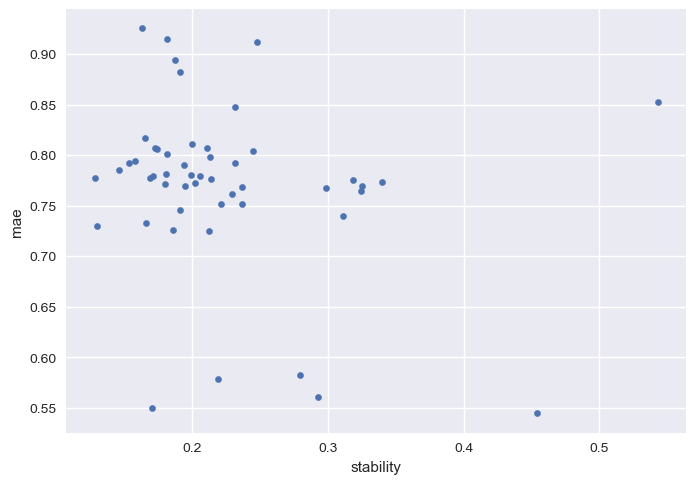

In [56]:
all_metrics_df.plot.scatter(y="mae", x="stability")

<AxesSubplot:xlabel='stability', ylabel='mae_2020'>

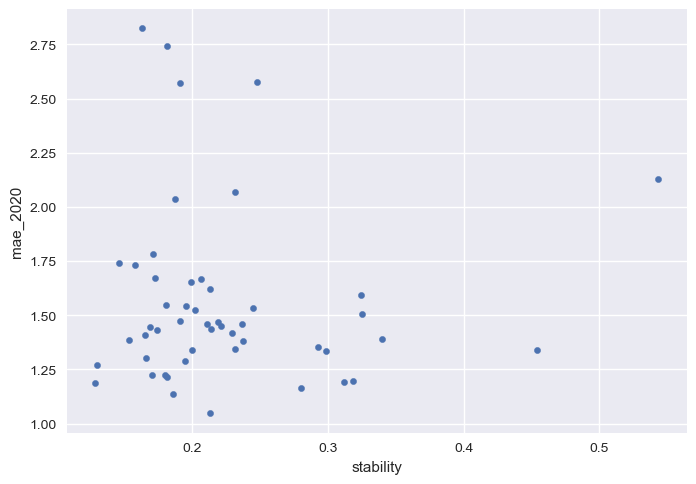

In [57]:
all_metrics_df.plot.scatter(y="mae_2020", x="stability")

<AxesSubplot:xlabel='stability', ylabel='mse'>

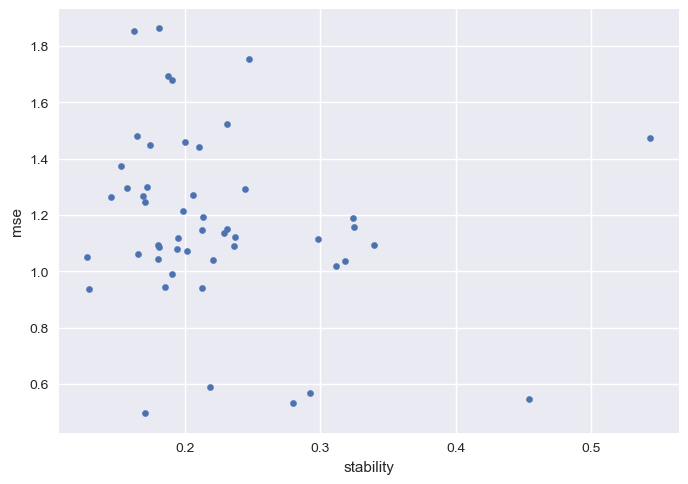

In [58]:
all_metrics_df.plot.scatter(y="mse", x="stability")

<AxesSubplot:xlabel='stability', ylabel='mse_2020'>

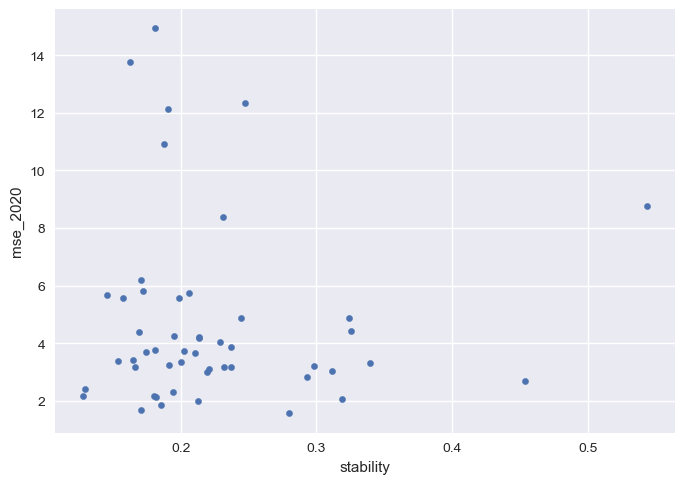

In [59]:
all_metrics_df.plot.scatter(y="mse_2020", x="stability")